# Подключение библиотеки

In [5]:
import timeit
import time
import sys
import os
import re
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from scipy import stats as st
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Многозадачная регрессия
from sklearn.multioutput import MultiOutputRegressor
# Для машинного обучения
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
# Метод ближайшего соседа KNN
from sklearn.neighbors import KNeighborsRegressor
# Метод опорного вектора, SVR - для регрессии
from sklearn.svm import SVR

# Метрики
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

# Нейросети
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Импорт и анализ данных

In [6]:
df = pd.read_csv('Amp_C_train.txt')

##### Рассмотрим содержимое датасет

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


In [8]:
# Приведение к нижнему регистру названия колонки
df.columns = df.columns.str.lower()

In [9]:
df.head()

time input                       output
0  0.000000e+00    0j    (1.0785e-42-9.30535e-43j)
1  5.000000e-09    0j   (4.00167e-44+4.80805e-45j)
2  1.000000e-08    0j   (5.73102e-46+1.23143e-45j)
3  1.500000e-08    0j  (-2.47356e-47+3.89672e-47j)
4  2.000000e-08    0j  (-1.56497e-48+2.91821e-51j)

# Предобработка данных

## Сделаем датасет в временной ряд

In [10]:
# Установка колонки 'time' в качестве индекса
df.set_index('time', inplace=True)

## Преобразование комплексных входных и выходных сигналов из строкового представления

In [11]:
df['input'] = df['input'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))
df['output'] = df['output'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))

## Изменим DataFrame с реальной и мнимой частями комплексных чисел

In [12]:
df['input_real'] = df['input'].apply(np.real)
df['input_imag'] = df['input'].apply(np.imag)
df['output_real'] = df['output'].apply(np.real)
df['output_imag'] = df['output'].apply(np.imag)

In [13]:
df.head()

input                                          output  \
time                                                                     
0.000000e+00  0.0+0.0j  1.078500e-42-9.305350e-                    43j   
5.000000e-09  0.0+0.0j  4.001670e-44+4.808050e-                    45j   
1.000000e-08  0.0+0.0j  5.731020e-46+1.231430e-                    45j   
1.500000e-08  0.0+0.0j -2.473560e-47+3.896720e-                    47j   
2.000000e-08  0.0+0.0j -1.564970e-48+2.918210e-                    51j   

              input_real  input_imag   output_real   output_imag  
time                                                              
0.000000e+00         0.0         0.0  1.078500e-42 -9.305350e-43  
5.000000e-09         0.0         0.0  4.001670e-44  4.808050e-45  
1.000000e-08         0.0         0.0  5.731020e-46  1.231430e-45  
1.500000e-08         0.0         0.0 -2.473560e-47  3.896720e-47  
2.000000e-08         0.0         0.0 -1.564970e-48  2.918210e-51

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172032 entries, 0.0 to 0.000860155
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype     
---  ------       --------------   -----     
 0   input        172032 non-null  complex128
 1   output       172032 non-null  complex128
 2   input_real   172032 non-null  float64   
 3   input_imag   172032 non-null  float64   
 4   output_real  172032 non-null  float64   
 5   output_imag  172032 non-null  float64   
dtypes: complex128(2), float64(4)
memory usage: 11.8 MB


In [15]:
df = df.drop(['input', 'output'], axis=1)

In [16]:
df.describe()

input_real     input_imag    output_real    output_imag
count  172032.000000  172032.000000  172032.000000  172032.000000
mean        0.000053      -0.000013      -0.001947      -0.000626
std         0.592007       0.593872       2.087976       2.087590
min        -2.229120      -2.202991      -3.449150      -3.441910
25%        -0.399091      -0.399775      -1.934853      -1.937512
50%        -0.000685      -0.000342      -0.010191       0.004920
75%         0.398777       0.401744       1.935345       1.929125
max         2.212461       2.192265       3.451210       3.460060

## График

In [17]:
def draw_plot_signal(signal_type, time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index

    # Построение объединенного графика
    plt.figure(figsize=(10, 6))
    
    # Входной сигнал
    plt.plot(time, filtered_data[f'{signal_type}_real'], label=f'{signal_type} Real Part', color='blue', linestyle='-')
    plt.plot(time, filtered_data[f'{signal_type}_imag'], label=f'{signal_type} Imaginary Part', color='red', linestyle='-')
    
    plt.title('Input and Output Signals')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
def draw_all_plot_signal(time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index
    
    plt.figure(figsize=(15, 10))

    # График реальной части входного сигнала
    plt.subplot(2, 2, 1)
    plt.plot(time, filtered_data['input_real'], label='Real Part')
    plt.title('Real Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части входного сигнала
    plt.subplot(2, 2, 2)
    plt.plot(time, filtered_data['input_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График реальной части выходного сигнала
    plt.subplot(2, 2, 3)
    plt.plot(time, filtered_data['output_real'], label='Real Part')
    plt.title('Real Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части выходного сигнала
    plt.subplot(2, 2, 4)
    plt.plot(time, filtered_data['output_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

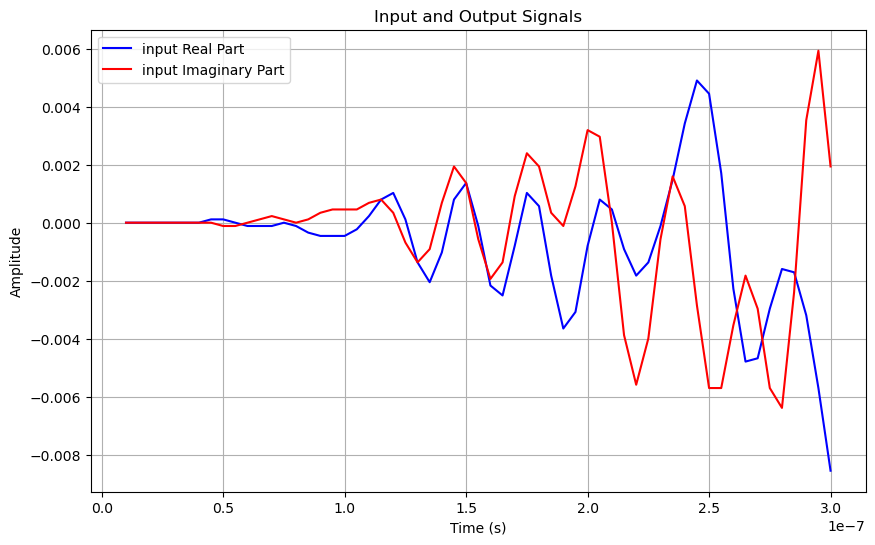

In [19]:
draw_plot_signal('input', time_start=1e-8, time_end=0.3e-6)

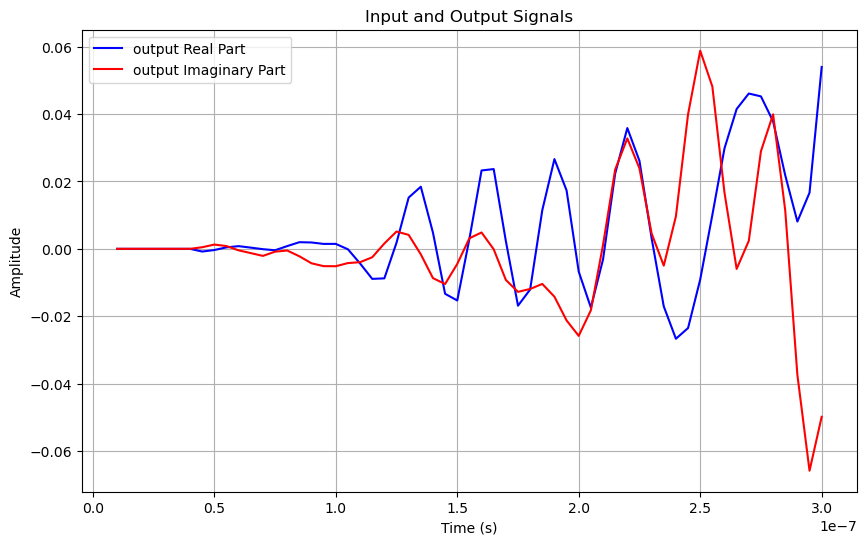

In [20]:
draw_plot_signal('output', time_start=1e-8, time_end=0.3e-6)

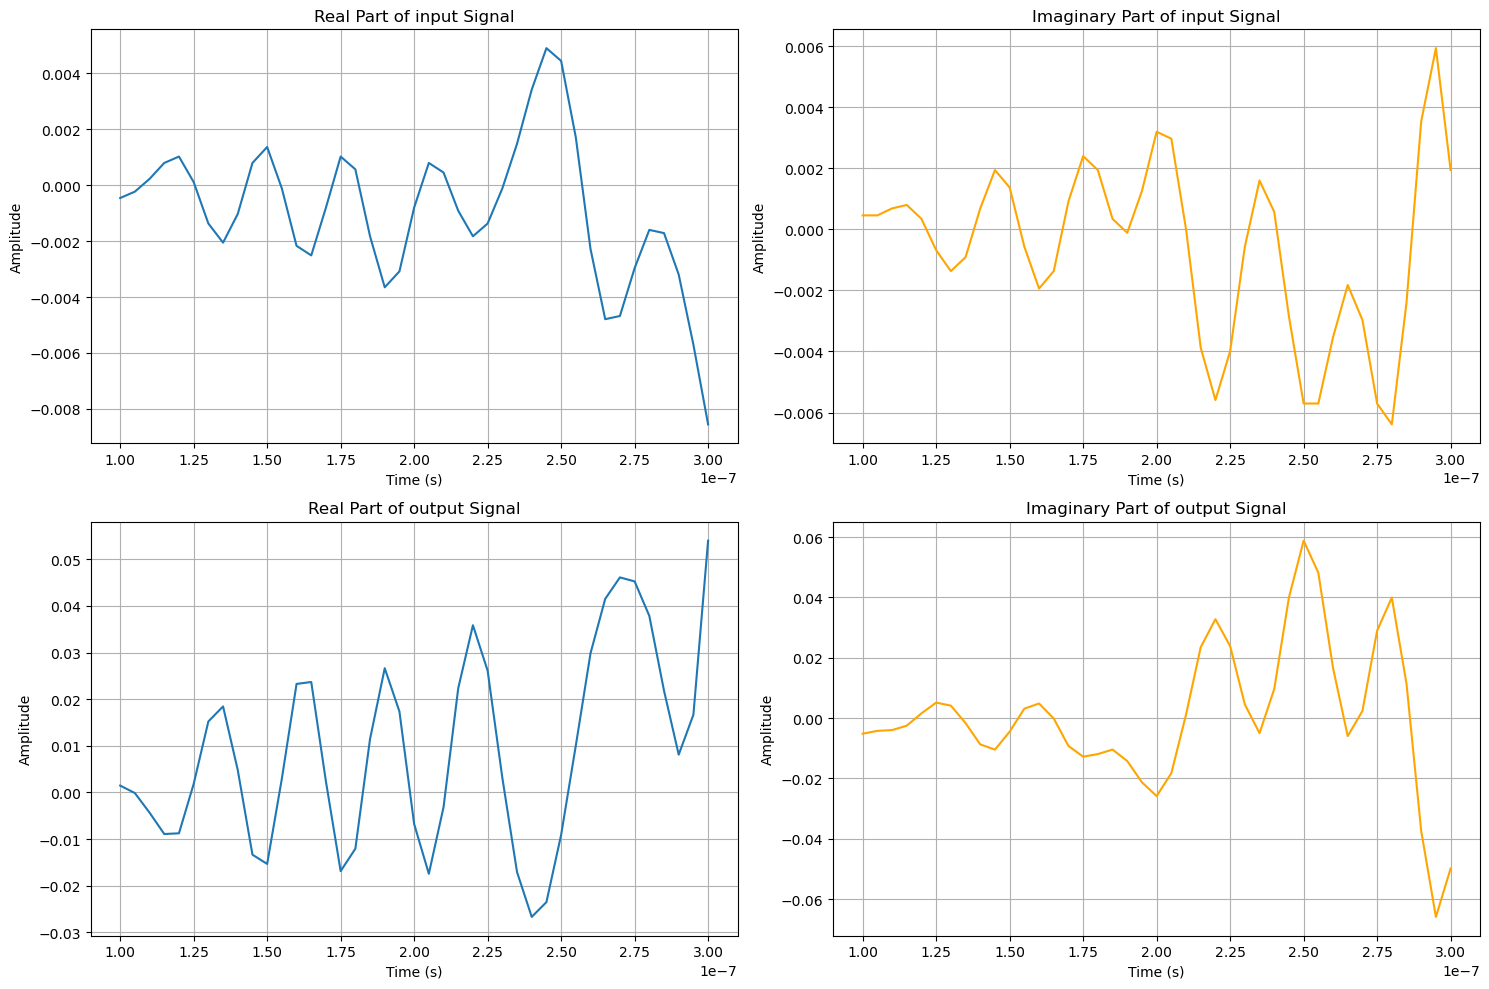

In [21]:
draw_all_plot_signal(time_start=1e-7, time_end=0.3e-6)

# Нейронное обучение

In [22]:
# Здесь будем сохранить результаты обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

Сложные динамические NN-модели можно разделить на три основных архитектурных класса следующим образом:

1. Complex Time Delay Recurrent Neural Network (CTRNN).
2. Complex Time Delay Neural Network (CTDNN).
3. Real Valued Time delay Recurrent Neural Network (RVTDRNN).
4. Real Valued Time Delay Neural Network (RVTDNN), also named as the Real
Valued Focused Time Delay Neural Network (RVFTDNN).

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172032 entries, 0.0 to 0.000860155
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   input_real   172032 non-null  float64
 1   input_imag   172032 non-null  float64
 2   output_real  172032 non-null  float64
 3   output_imag  172032 non-null  float64
dtypes: float64(4)
memory usage: 6.6 MB


In [24]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


## Сложные динамические NN-модели

### Complex Time Delay Recurrent Neural Network (CTRNN)

In [25]:
# Функция для создания временных окон с задержками для входа и выхода
def create_time_delays_with_feedback(X_real, X_imag, Y_real, Y_imag, p, q):
    X_delayed = []
    Y_delayed = []
    
    for i in range(max(p, q), len(X_real)):
        # Входные задержки для X_real и X_imag
        X_real_window = X_real.iloc[i-p:i+1].values  # Входные задержки (x(k), x(k-1), ..., x(k-p))
        X_imag_window = X_imag.iloc[i-p:i+1].values
        
        # Обратная связь для Y_real и Y_imag
        Y_real_window = Y_real.iloc[i-q:i].values  # Обратная связь (y(k-1), y(k-2), ..., y(k-q))
        Y_imag_window = Y_imag.iloc[i-q:i].values
        
        # Комбинируем вещественные и мнимые части
        X_combined = np.concatenate([X_real_window, X_imag_window, Y_real_window, Y_imag_window])
        
        X_delayed.append(X_combined)
        
        # Текущие значения выходных данных
        Y_combined = np.array([Y_real.iloc[i], Y_imag.iloc[i]])
        Y_delayed.append(Y_combined)
    
    return np.array(X_delayed), np.array(Y_delayed)

In [26]:
# Параметры задержек (p и q)
p = 10  # Входная задержка
q = 5   # Выходная задержка

In [27]:
%%time
# Создание временных последовательностей с задержками и обратной связью
X_seq, Y_seq = create_time_delays_with_feedback(
    df['input_real'], 
    df['input_imag'], 
    df['output_real'], 
    df['output_imag'], 
    p, q
)

CPU times: user 12.1 s, sys: 848 ms, total: 13 s
Wall time: 11.9 s


In [28]:
# Нормализация данных
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_seq)
Y_scaled = scaler_Y.fit_transform(Y_seq)

In [29]:
# Преобразование данных в тензоры PyTorch с добавлением временного измерения
X_train_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1).to(device)  # Добавляем временное измерение и переносим на device
Y_train_tensor = torch.tensor(Y_scaled, dtype=torch.float32).to(device)

In [30]:
# Создание DataLoader для мини-батчей
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [31]:
# Определение модели CTDRNN
class CTDRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CTDRNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Используем последний временной шаг
        return out

In [32]:
# Параметры модели
input_size = 2 * (p + 1 + q)  # Входные и выходные задержки (вещественная и мнимая части)
hidden_size = 100
output_size = 2  # Вещественная и мнимая часть выходного сигнала
num_layers = 2
num_epochs = 100
learning_rate = 0.001

In [33]:
# Инициализация модели, функции потерь и оптимизатора
model = CTDRNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
%%time
# Список для хранения значений функции потерь
loss_values = []

# Задержка для измерения времени
start_time = time.time()

# Обучение модели
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, Y_batch in train_loader:
        # Перенос батчей на GPU
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  
        
        # Прямой проход
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        
        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X_batch.size(0)  # Умножаем на размер батча для подсчета средней потери

    # Сохраняем среднее значение функции потерь для текущей эпохи
    avg_loss = epoch_loss / len(train_loader.dataset)
    loss_values.append(avg_loss)

    # if (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

end_time = time.time()
elapsed = end_time - start_time

Epoch [1/100], Loss: 0.028485
Epoch [2/100], Loss: 0.000672
Epoch [3/100], Loss: 0.000304
Epoch [4/100], Loss: 0.000217
Epoch [5/100], Loss: 0.000185
Epoch [6/100], Loss: 0.000167
Epoch [7/100], Loss: 0.000152
Epoch [8/100], Loss: 0.000142
Epoch [9/100], Loss: 0.000134
Epoch [10/100], Loss: 0.000127
Epoch [11/100], Loss: 0.000120
Epoch [12/100], Loss: 0.000116
Epoch [13/100], Loss: 0.000110
Epoch [14/100], Loss: 0.000105
Epoch [15/100], Loss: 0.000101
Epoch [16/100], Loss: 0.000097
Epoch [17/100], Loss: 0.000094
Epoch [18/100], Loss: 0.000088
Epoch [19/100], Loss: 0.000087
Epoch [20/100], Loss: 0.000083
Epoch [21/100], Loss: 0.000084
Epoch [22/100], Loss: 0.000076
Epoch [23/100], Loss: 0.000076
Epoch [24/100], Loss: 0.000072
Epoch [25/100], Loss: 0.000069
Epoch [26/100], Loss: 0.000068
Epoch [27/100], Loss: 0.000064
Epoch [28/100], Loss: 0.000062
Epoch [29/100], Loss: 0.000061
Epoch [30/100], Loss: 0.000059
Epoch [31/100], Loss: 0.000058
Epoch [32/100], Loss: 0.000056
Epoch [33/100], L

In [ ]:
# Создаем фигуру с двумя подграфиками
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Первый график — начиная с эпохи 1
epoch_start = 1
axs[0].plot(range(epoch_start, num_epochs + 1), loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Average Loss')
axs[0].set_title('Loss Function (starting from Epoch 1)')
axs[0].grid(True)

# Второй график — начиная с эпохи 3
epoch_start = 3
axs[1].plot(range(epoch_start, num_epochs + 1), loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Average Loss')
axs[1].set_title('Loss Function (starting from Epoch 3)')
axs[1].grid(True)

# Показываем оба графика
plt.tight_layout()
plt.show()

In [ ]:
# Оценка модели
model.eval()  # Переключение в режим оценки
with torch.no_grad():
    Y_pred_scaled = model(X_train_tensor).cpu().numpy()
    Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
    rmse_real = np.sqrt(mean_squared_error(Y_seq[:, 0], Y_pred[:, 0]))
    rmse_imag = np.sqrt(mean_squared_error(Y_seq[:, 1], Y_pred[:, 1]))

print(f'RMSE (Real part): {rmse_real}')
print(f'RMSE (Imaginary part): {rmse_imag}')

In [ ]:
# Заполнение результатов
results[count_model] = pd.Series({
    'NAME': 'CTDRNN',  # Название модели
    'RMSE TRAIN': None,
    'RMSE VALID REAL': rmse_real,
    'RMSE VALID IMAG': rmse_imag,
    'TIME TRAINING [s]': elapsed,
    'TIME PREDICTION [s]': None,
    'PREDICTIONS': Y_pred,
    'PARAMETRS': model.state_dict()  # Хранение параметров модели
})

display(results[count_model])
count_model += 1

In [40]:
# Пример структуры DataFrame для info_result:
# Создание DataFrame с реальными и предсказанными значениями
info_result = pd.DataFrame({
    'default_real': Y_seq[:, 0],  # Реальные значения (вещественная часть)
    'default_imag': Y_seq[:, 1],  # Реальные значения (мнимая часть)
    'pred_real': Y_pred[:, 0],    # Предсказанные значения (вещественная часть)
    'pred_imag': Y_pred[:, 1]     # Предсказанные значения (мнимая часть)
})

# Если у вас есть временные метки:
info_result.index = range(len(Y_seq))  # Пример временной шкалы: индексы от 0 до количества наблюдений

In [65]:
def plot_predictions_vs_real(info_result, time_start, time_end):
    # Фильтрация данных по временной отметке
    filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
    time = filtered_data.index

    # Создание фигуры с двумя подграфиками
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
    
    # Общий заголовок для всей фигуры
    fig.suptitle('Comparison of Real and Predicted Values', fontsize=22)

    # Построение графиков реальных и предсказанных значений (вещественная часть)
    axs[0].plot(time, filtered_data['default_real'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
    axs[0].plot(time, filtered_data['pred_real'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
    axs[0].legend(fontsize='xx-large')
    axs[0].grid()
    axs[0].set_xlabel('Time', fontsize=20)
    axs[0].set_ylabel('Real Part', fontsize=20)
    axs[0].set_title('Real Part: Default vs Predicted', fontsize=20)

    # Построение графиков реальных и предсказанных значений (мнимая часть)
    axs[1].plot(time, filtered_data['default_imag'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
    axs[1].plot(time, filtered_data['pred_imag'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
    axs[1].legend(fontsize='xx-large')
    axs[1].grid()
    axs[1].set_xlabel('Time', fontsize=20)
    axs[1].set_ylabel('Imaginary Part', fontsize=20)
    axs[1].set_title('Imaginary Part: Default vs Predicted', fontsize=20)

    # Показываем график
    plt.tight_layout()
    plt.show()

In [66]:
plot_predictions_vs_real(info_result, time_start=0, time_end=1.005e2)

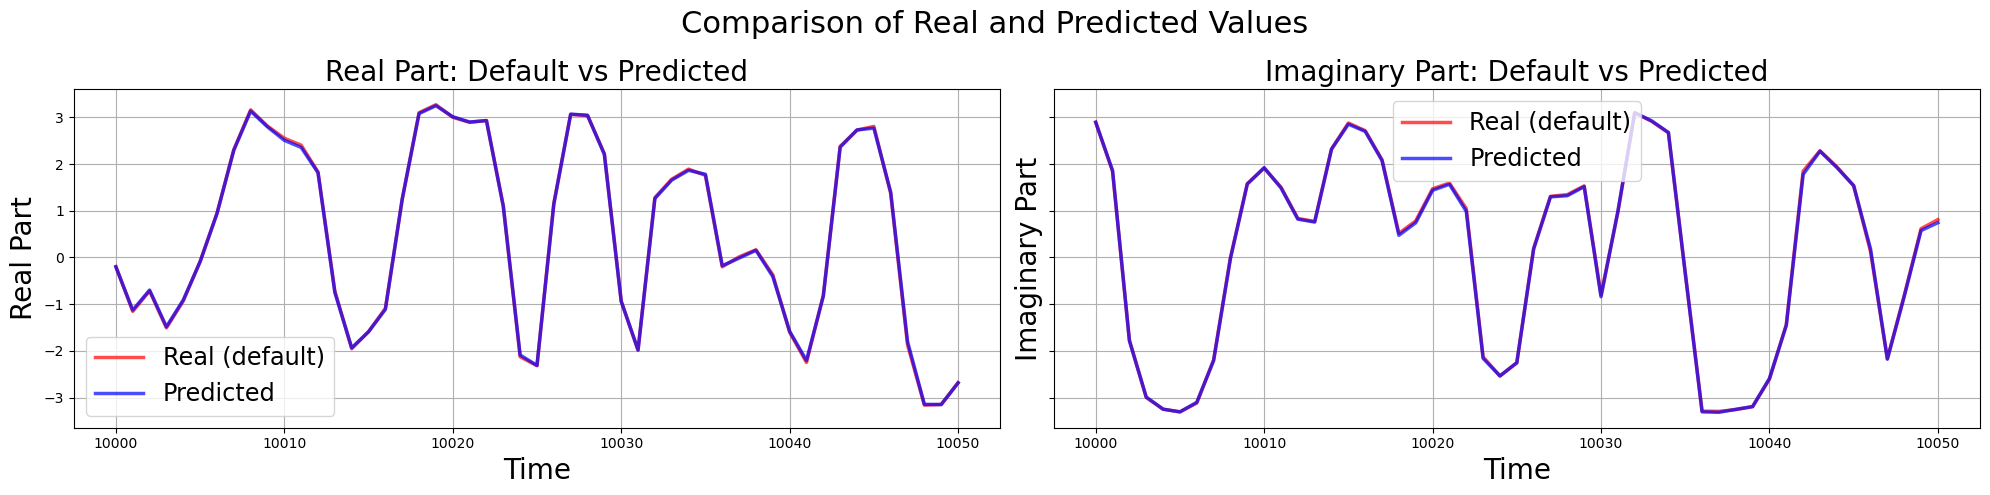

In [67]:
plot_predictions_vs_real(info_result, time_start=1e4, time_end=1.005e4)

### Complex Time Delay Neural Network (CTDNN)

### Real Valued Time delay Recurrent Neural Network (RVTDRNN)

### Real Valued Focused Time Delay Neural Network (RVFTDNN)

### Real Valued Recurrent Neural Network (RVRNN)

## Результаты

In [34]:
results = pd.DataFrame(results).T

In [35]:
# Смотрим на результаты
results

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG TIME TRAINING [s]  \
0  CTDRNN       None        0.025553        0.024216          73.41909   

  TIME PREDICTION [s]                                        PREDICTIONS  \
0                None  [[-0.012239576, -2.7782056e-05], [-0.011480750...   

                                           PARAMETRS  
0  {'lstm.weight_ih_l0': [[tensor(-0.0006, device...

In [36]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.45 * (1 - (results['RMSE VALID REAL'] / results['RMSE VALID REAL'].max())) +
    0.45 * (1 - (results['RMSE VALID IMAG'] / results['RMSE VALID IMAG'].max())) +
    0.1 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [37]:
# Смотрим на результаты
display(results)

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG TIME TRAINING [s]  \
0  CTDRNN       None        0.025553        0.024216          73.41909   

  TIME PREDICTION [s]                                        PREDICTIONS  \
0                None  [[-0.012239576, -2.7782056e-05], [-0.011480750...   

                                           PARAMETRS RATING  
0  {'lstm.weight_ih_l0': [[tensor(-0.0006, device...    0.0

**Создадим отдельный датасет, в котором будет храниться реальное значение и предсказания модели**

In [38]:
# Используем индексы валидационных данных
info_result = pd.DataFrame(index=targets_valid.index)

info_result['default_real'] = targets_valid['output_real']
info_result['default_imag'] = targets_valid['output_imag']

for i, name_model in enumerate(results['NAME']):
    info_result[name_model+'_real'] = results['PREDICTIONS'][i][:, 0]  # Предсказанные значения действительной части
    info_result[name_model+'_imag'] = results['PREDICTIONS'][i][:, 1]  # Предсказанные значения действительной части

# Сортировка DataFrame по индексу
info_result = info_result.sort_index()

info_result.head()

NameError: name 'targets_valid' is not defined

In [75]:
def plot_predictions_vs_real(info_result, time_start, time_end):
    # Определяем количество моделей, минус 1 для 'default_real' и 'default_imag'
    num_models = len(info_result.columns) // 2 - 1  

    for i in range(num_models):
        col_real = 'default_real'
        col_pred_real = info_result.columns[2 * i + 2]
        col_pred_imag = info_result.columns[2 * i + 3]

        # Фильтрация данных по временной отметке
        filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
        time = filtered_data.index

        # Создание фигуры с двумя подграфиками
        fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
        
        # Общий заголовок для всей фигуры
        fig.suptitle(f'Graph of default and predicted values ({col_pred_real.split("_")[0]})', fontsize=22)

        # Построение графиков реальных значений
        axs[0].plot(time, filtered_data[col_real], alpha=0.7, color='red', lw=2.5, label='default')
        axs[0].plot(time, filtered_data[col_pred_real], alpha=0.7, color='blue', lw=2.5, label='prediction')
        axs[0].legend(fontsize='xx-large')
        axs[0].grid()
        axs[0].set_xlabel('Time series', fontsize=20)
        axs[0].set_ylabel('Value', fontsize=20)
        axs[0].set_title('REAL', fontsize=20)

        # Построение графиков мнимых значений
        axs[1].plot(time, filtered_data['default_imag'], alpha=0.7, color='red', lw=2.5, label='default')
        axs[1].plot(time, filtered_data[col_pred_imag], alpha=0.7, color='blue', lw=2.5, label='prediction')
        axs[1].legend(fontsize='xx-large')
        axs[1].grid()
        axs[1].set_xlabel('Time series', fontsize=20)
        axs[1].set_ylabel('Value', fontsize=20)
        axs[1].set_title('IMAG', fontsize=20)

        # Показываем график
        plt.tight_layout()
        plt.show()

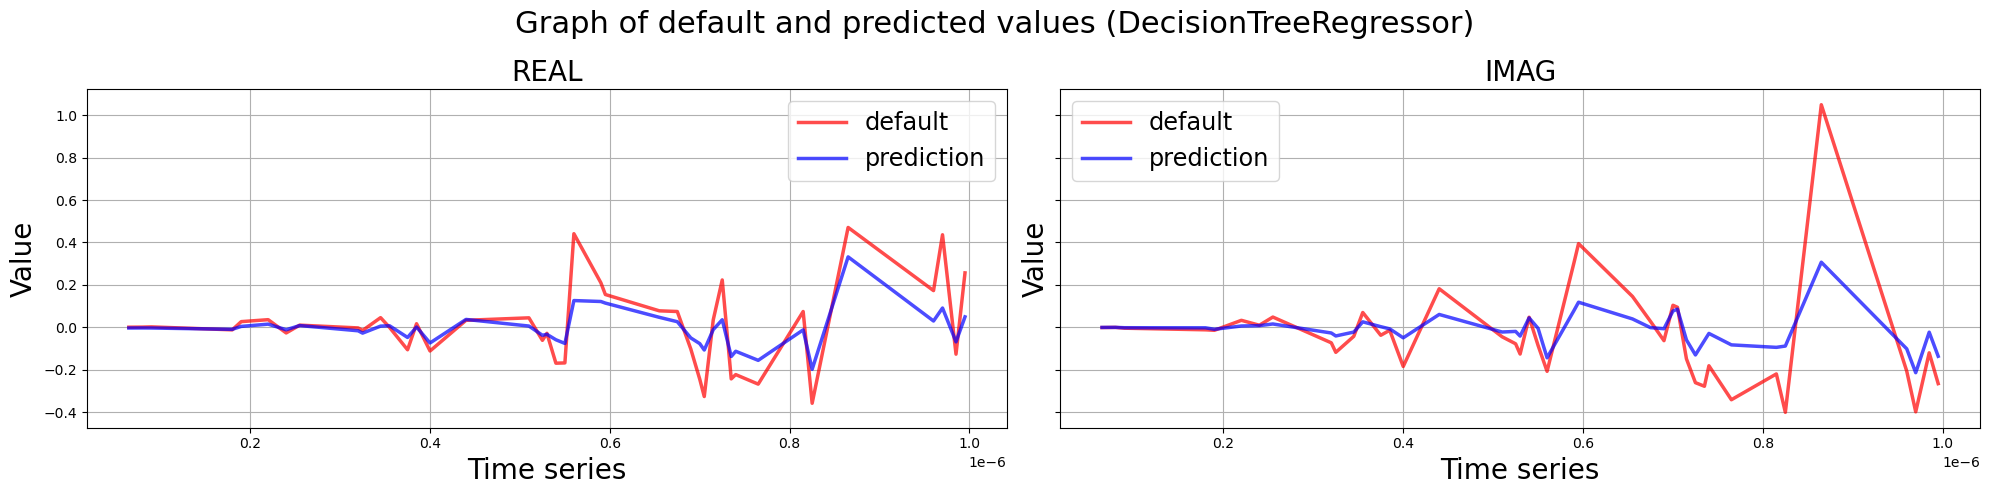

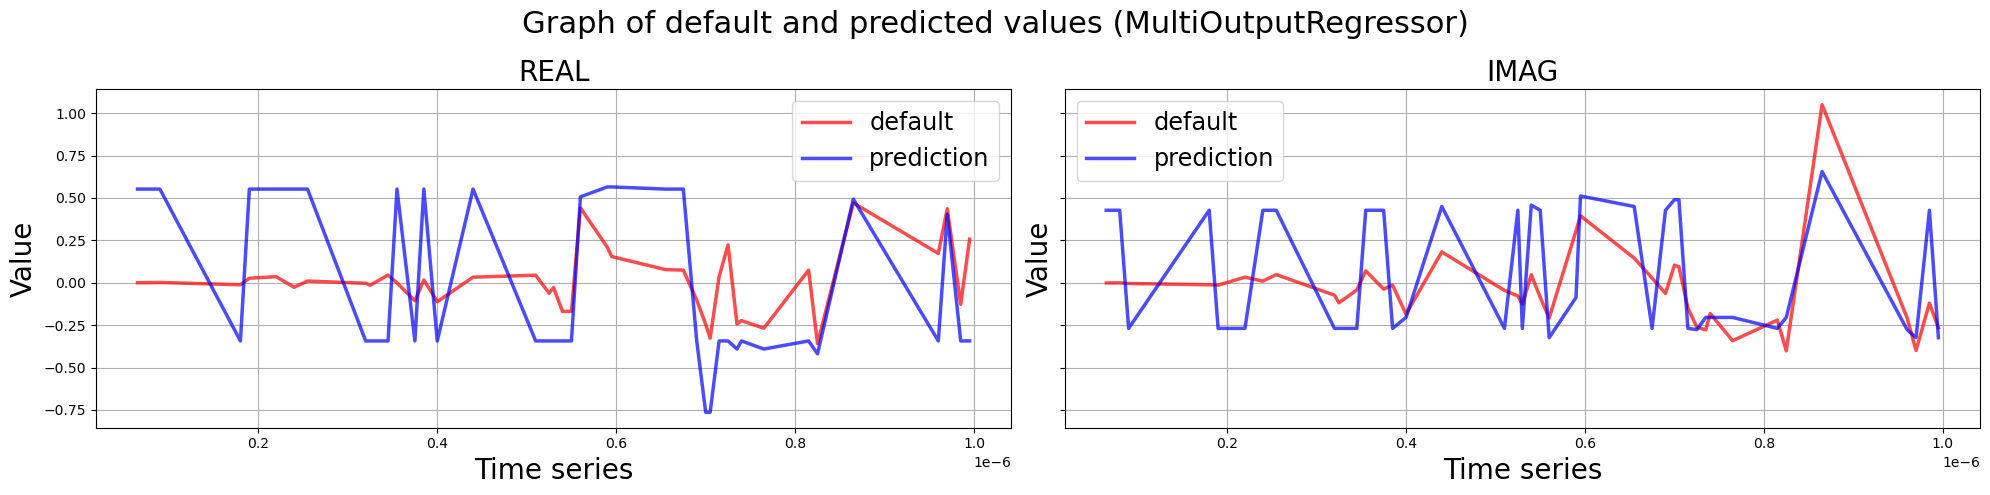

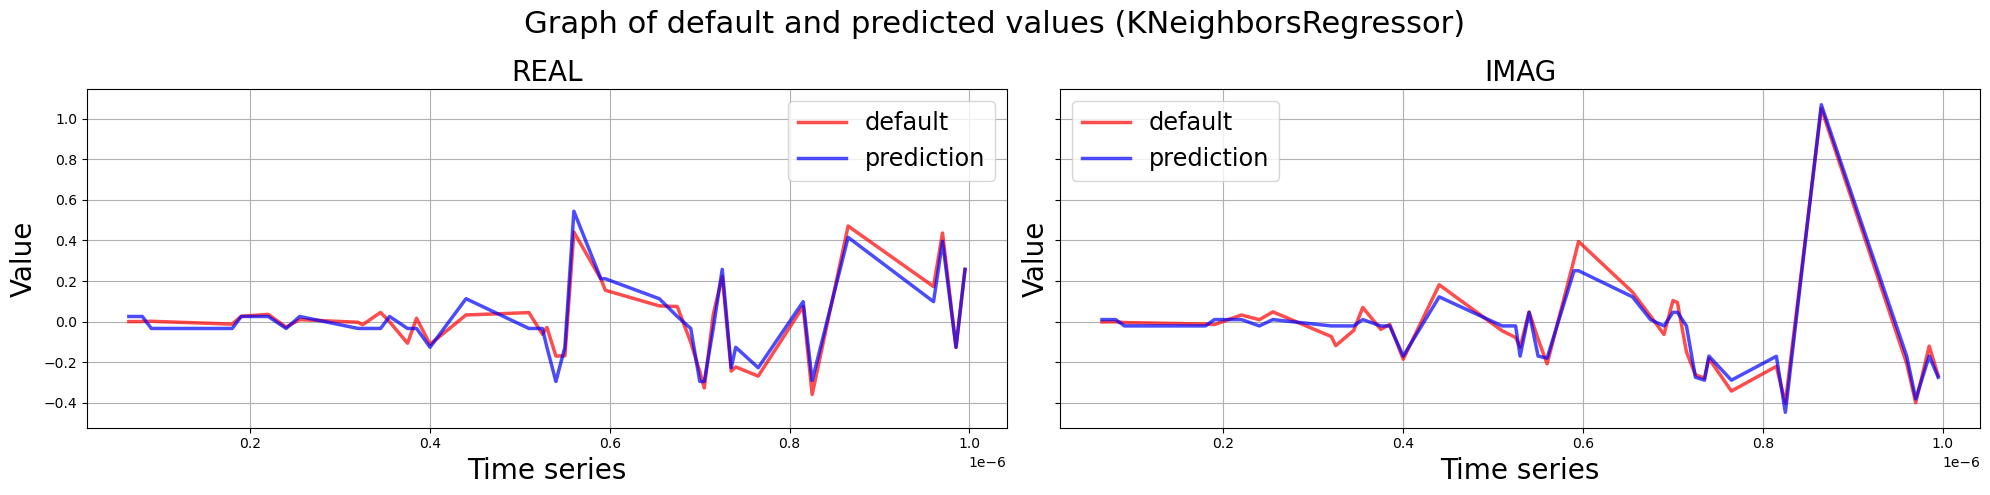

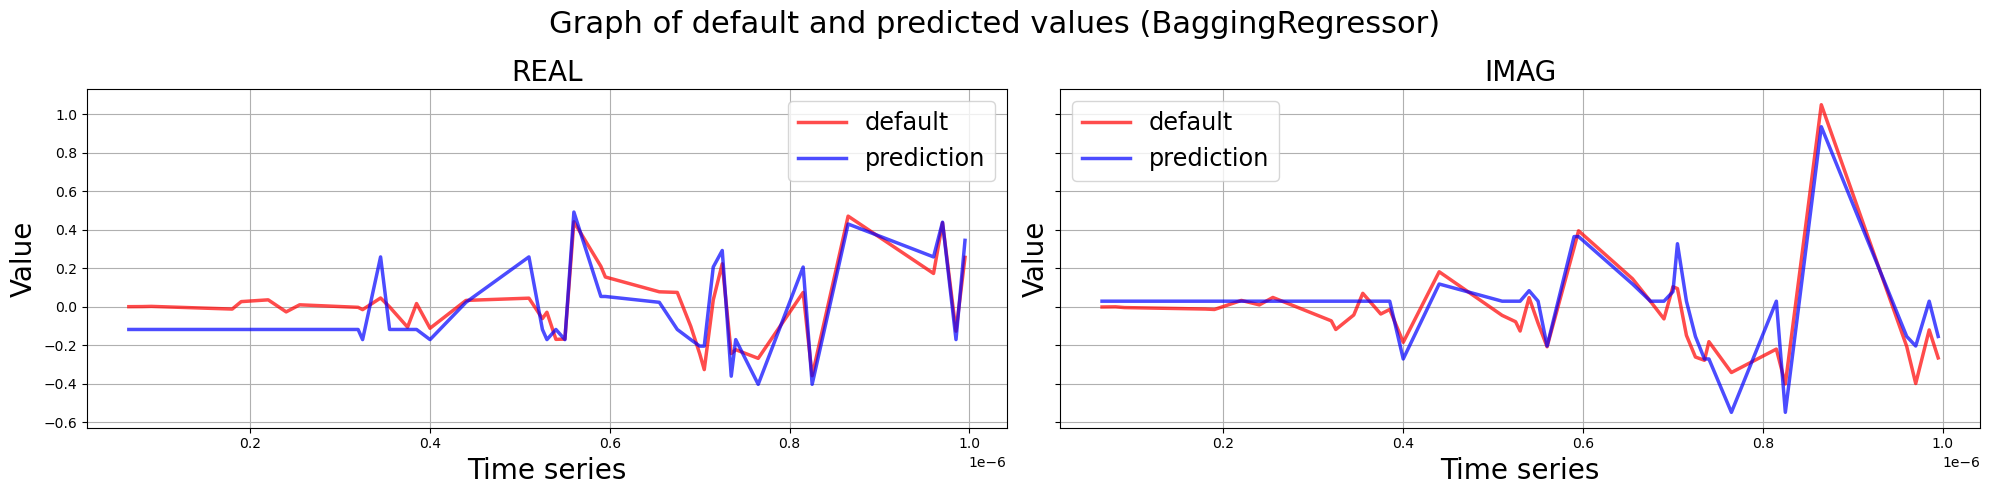

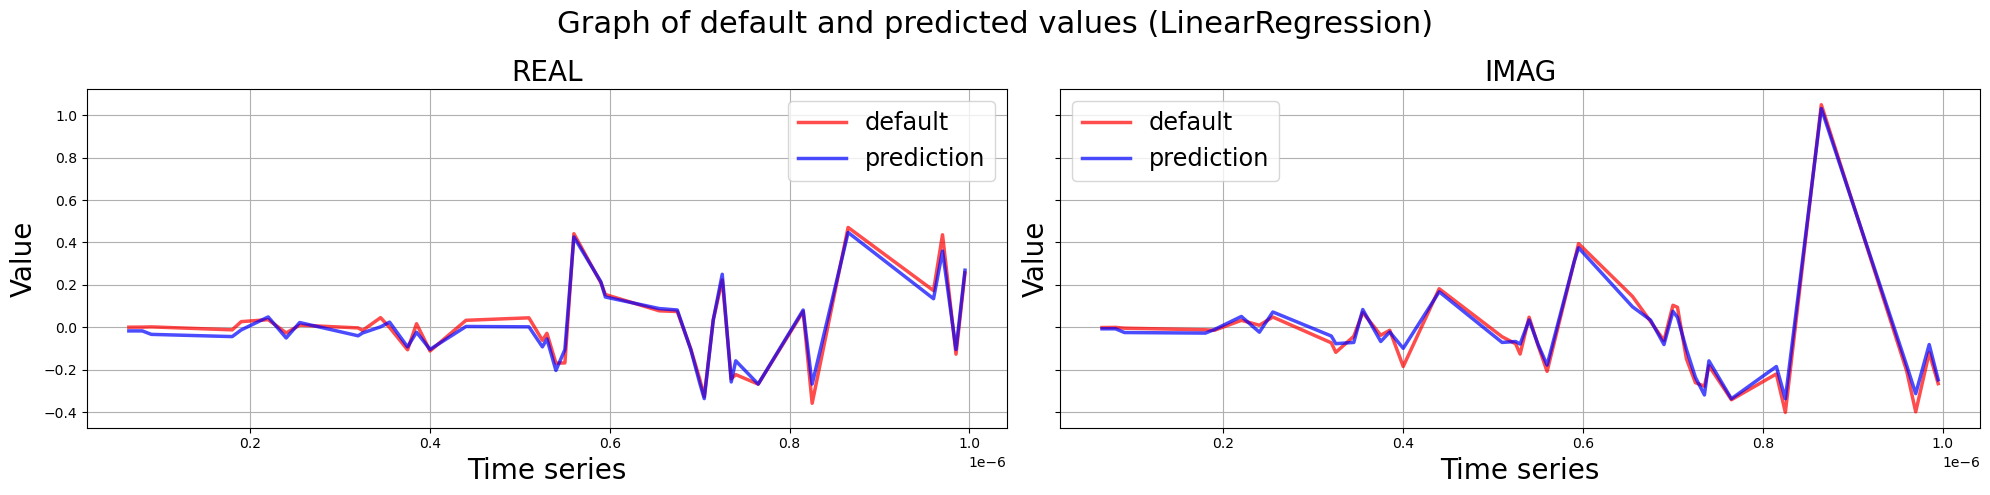

In [76]:
plot_predictions_vs_real(info_result, time_start=0, time_end=1e-6)

# Машинное обучение

In [18]:
# Здесь будем сохранить результаты обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

In [42]:
# Определение входных и выходных данных
features = df[['input_real', 'input_imag']]
targets = df[['output_real', 'output_imag']]

## Деление на обучающей и валидационной выборки

**Обучение моделей с применением TimeSeriesSplit**

Почему обучаем с применением TimeSeriesSplit, потому что мы обучаем модель, у которой по индексу стоит временный ряд. А чтобы они не пересекались, это поможет инструмент TimeSeriesSplit.

In [43]:
# Не будем создавать по-умолчанию, где n_splits=5, а установим n_splits=10
tscv = TimeSeriesSplit(10)
display(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

In [44]:
# Разделение на обучающую и валидационную выборки
features_train, features_valid, targets_train, targets_valid = train_test_split(features, targets, test_size=0.2, random_state=123456)

## Обучение модели

### LinearRegression

In [45]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), LinearRegression())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={}, scoring='neg_root_mean_squared_error')

In [46]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.8658672581599522
TIME TRAIN [s]: 0.02


**Проверка на валидационной выборки**

In [47]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.7488804442530592
RMSE для мнимой части: 0.7531629903468988
CPU times: user 16.3 ms, sys: 3 ms, total: 19.3 ms
Wall time: 4.52 ms


In [48]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                    LinearRegression
RMSE TRAIN                                                      0.865867
RMSE VALID REAL                                                  0.74888
RMSE VALID IMAG                                                 0.753163
TIME TRAINING [s]                                               0.022211
TIME PREDICTION [s]                                                0.003
PREDICTIONS            [[-0.28832698573917814, 1.936889405288186], [-...
PARAMETRS                                                             {}
Name: 1, dtype: object

### KNeighborsRegressor

In [49]:
# Задаем значения гиперпараметров
parameters = {
    # Пример значений, можно добавить свои
    'kneighborsregressor__n_neighbors': [1, 2],  
    # 'weights': ['uniform', 'distance'],
    'kneighborsregressor__weights': ['uniform'],
    # для параметра метрики (1 - манхэттенское расстояние, 2 - евклидово расстояние)
    # 'kneighborsregressor__p': [1]  
}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), KNeighborsRegressor())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [1, 2],
                         'kneighborsregressor__weights': ['uniform']},
             scoring='neg_root_mean_squared_error')

In [50]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.3862943803573481
TIME TRAIN [s]: 0.06


**Проверка на валидационной выборки**

In [51]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.14756557815883273
RMSE для мнимой части: 0.1483683860179619
CPU times: user 77 ms, sys: 1.02 ms, total: 78 ms
Wall time: 76.1 ms


In [52]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                 KNeighborsRegressor
RMSE TRAIN                                                      0.386294
RMSE VALID REAL                                                 0.147566
RMSE VALID IMAG                                                 0.148368
TIME TRAINING [s]                                               0.058181
TIME PREDICTION [s]                                                0.075
PREDICTIONS            [[-0.44020349999999997, 2.974165], [-2.74305, ...
PARAMETRS              {'kneighborsregressor__n_neighbors': 2, 'kneig...
Name: 2, dtype: object

### DecisionTreeRegressor

In [53]:
parameters = {
    'decisiontreeregressor__max_depth': range(1, 101, 10),
    'decisiontreeregressor__min_samples_leaf': [1, 0.5]
}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=12345))
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=12345))]),
             param_grid={'decisiontreeregressor__max_depth': range(1, 101, 10),
                         'decisiontreeregressor__min_samples_leaf': [1, 0.5]},
             scoring='neg_root_mean_squared_error')

In [54]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.37621486671960813
TIME TRAIN [s]: 0.27


**Проверка на валидационной выборки**

In [55]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.13459805580403986
RMSE для мнимой части: 0.1339878847137597
CPU times: user 6.48 ms, sys: 1.06 ms, total: 7.54 ms
Wall time: 5.99 ms


In [56]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                               DecisionTreeRegressor
RMSE TRAIN                                                      0.376215
RMSE VALID REAL                                                 0.134598
RMSE VALID IMAG                                                 0.133988
TIME TRAINING [s]                                                0.27373
TIME PREDICTION [s]                                                0.005
PREDICTIONS            [[-0.5637410662983423, 2.8974165193370167], [-...
PARAMETRS              {'decisiontreeregressor__max_depth': 11, 'deci...
Name: 3, dtype: object

### LightGBMRegressor

In [57]:
# Матрица гиперпараметров для LGBMRegressor
parameters = {
    'multioutputregressor__estimator__n_estimators': [10, 25],
    'multioutputregressor__estimator__learning_rate': [0.1, 0.3],
    'multioutputregressor__estimator__max_depth': [5, 15],
    'multioutputregressor__estimator__num_leaves': [5, 10],
}

# Оборачиваем LGBMR в MultiOutputRegressor
multi_target_lgbmr = MultiOutputRegressor(LGBMRegressor())

# Инициализируем модель с параметрами и создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), multi_target_lgbmr)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=LGBMRegressor()))]),
             param_grid={'multioutputregressor__estimator__learning_rate': [0.1,
                                                                            0.3],
                         'multioutputregressor__estimator__max_depth': [5, 15],
                         'multioutputregressor__estimator__n_estimators': [10,
                                                                           25],
                         'multioutputregressor__estimator__num_leaves': [5,
                                                                         10]},
             scoring='neg_root_mean_squared_error')

In [58]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12515, number of used features: 2
[LightGBM] [Info] Start training from score 0.003815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12515, number of used features: 2
[LightGBM] [Info] Start training from score 0.015188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 25026, number of used features: 2
[LightGBM] [Info] Start training 

**Проверка на валидационной выборки**

In [59]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.1713299102926755
RMSE для мнимой части: 0.1723867719656781
CPU times: user 97.4 ms, sys: 3.9 ms, total: 101 ms
Wall time: 12.6 ms


In [60]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                MultiOutputRegressor
RMSE TRAIN                                                      0.416362
RMSE VALID REAL                                                  0.17133
RMSE VALID IMAG                                                 0.172387
TIME TRAINING [s]                                               0.084823
TIME PREDICTION [s]                                                0.012
PREDICTIONS            [[-0.33606733176649484, 3.0045329003957586], [...
PARAMETRS              {'multioutputregressor__estimator__learning_ra...
Name: 4, dtype: object

### CatBoostRegressor

In [61]:
# Матрица гиперпараметров для CatBoostRegressor
parameters = {
    'multioutputregressor__estimator__iterations': [5, 10],
    'multioutputregressor__estimator__learning_rate': [0.1, 0.5],
    'multioutputregressor__estimator__depth': [5, 15],
}

# Оборачиваем CatBoostRegressor в MultiOutputRegressor
multi_target_cbr = MultiOutputRegressor(CatBoostRegressor())

# Инициализируем модель с параметрами и создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), multi_target_cbr)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7d6bd48b2ad0>))]),
             param_grid={'multioutputregressor__estimator__depth': [5, 15],
                         'multioutputregressor__estimator__iterations': [5, 10],
                         'multioutputregressor__estimator__learning_rate': [0.1,
                                                                            0.5]},
             scoring='neg_root_mean_squared_error')

In [62]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

0:	learn: 1.9013737	total: 48.3ms	remaining: 193ms
1:	learn: 1.7306095	total: 49.9ms	remaining: 74.9ms
2:	learn: 1.5795488	total: 51.3ms	remaining: 34.2ms
3:	learn: 1.4394106	total: 52.8ms	remaining: 13.2ms
4:	learn: 1.3128407	total: 54.2ms	remaining: 0us
0:	learn: 1.9010003	total: 1.83ms	remaining: 7.34ms
1:	learn: 1.7313272	total: 3.13ms	remaining: 4.7ms
2:	learn: 1.5814113	total: 4.43ms	remaining: 2.95ms
3:	learn: 1.4447014	total: 5.78ms	remaining: 1.45ms
4:	learn: 1.3188330	total: 6.96ms	remaining: 0us
0:	learn: 1.9039942	total: 2.2ms	remaining: 8.82ms
1:	learn: 1.7343293	total: 3.84ms	remaining: 5.77ms
2:	learn: 1.5823872	total: 5.36ms	remaining: 3.57ms
3:	learn: 1.4419239	total: 7.05ms	remaining: 1.76ms
4:	learn: 1.3152449	total: 8.75ms	remaining: 0us
0:	learn: 1.9005997	total: 2.22ms	remaining: 8.87ms
1:	learn: 1.7316318	total: 4.12ms	remaining: 6.18ms
2:	learn: 1.5763051	total: 5.84ms	remaining: 3.89ms
3:	learn: 1.4377097	total: 7.62ms	remaining: 1.9ms
4:	learn: 1.3136369	total

**Проверка на валидационной выборки**

In [63]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.14433298570142392
RMSE для мнимой части: 0.1442852424131891
CPU times: user 17.7 ms, sys: 1.11 ms, total: 18.8 ms
Wall time: 5.7 ms


In [64]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                MultiOutputRegressor
RMSE TRAIN                                                       0.38449
RMSE VALID REAL                                                 0.144333
RMSE VALID IMAG                                                 0.144285
TIME TRAINING [s]                                               5.382834
TIME PREDICTION [s]                                                0.005
PREDICTIONS            [[-0.5793409857007769, 3.00895793161571], [-2....
PARAMETRS              {'multioutputregressor__estimator__depth': 15,...
Name: 5, dtype: object

### BaggingRegressor

In [65]:
# Матрица гиперпараметров для BaggingRegressor
parameters = {
    'baggingregressor__n_estimators': [10, 25],
    'baggingregressor__random_state': [12345] 
}

# Инициализируем модель с параметрами и создаем конвейер
# Инициализируем BaggingRegressor отдельно
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10), random_state=12345)
pipeline_scale = make_pipeline(StandardScaler(), bagging_model)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('baggingregressor',
                                        BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                                                         random_state=12345))]),
             param_grid={'baggingregressor__n_estimators': [10, 25],
                         'baggingregressor__random_state': [12345]},
             scoring='neg_root_mean_squared_error')

In [66]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.35696216171103107
TIME TRAIN [s]: 4.56


**Проверка на валидационной выборки**

In [67]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.12555557093909708
RMSE для мнимой части: 0.1261163382483048
CPU times: user 80.8 ms, sys: 0 ns, total: 80.8 ms
Wall time: 78.5 ms


In [68]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                    BaggingRegressor
RMSE TRAIN                                                      0.356962
RMSE VALID REAL                                                 0.125556
RMSE VALID IMAG                                                 0.126116
TIME TRAINING [s]                                               4.556865
TIME PREDICTION [s]                                                0.078
PREDICTIONS            [[-0.5211061075152857, 3.000718101419898], [-2...
PARAMETRS              {'baggingregressor__n_estimators': 25, 'baggin...
Name: 6, dtype: object

## Результаты

In [69]:
results = pd.DataFrame(results).T

In [70]:
# Смотрим на результаты
results

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG  \
0                 CTDRNN       None        0.012914        0.014553   
1       LinearRegression   0.865867         0.74888        0.753163   
2    KNeighborsRegressor   0.386294        0.147566        0.148368   
3  DecisionTreeRegressor   0.376215        0.134598        0.133988   
4   MultiOutputRegressor   0.416362         0.17133        0.172387   
5   MultiOutputRegressor    0.38449        0.144333        0.144285   
6       BaggingRegressor   0.356962        0.125556        0.126116   

  TIME TRAINING [s] TIME PREDICTION [s]  \
0         689.65646                None   
1          0.022211               0.003   
2          0.058181               0.075   
3           0.27373               0.005   
4          0.084823               0.012   
5          5.382834               0.005   
6          4.556865               0.078   

                                         PREDICTIONS  \
0  [[-0.004485002, 0.015285028], [-0.0036792648, ...   
1  [[-0.28832698573917814, 1.936889405288186], [-...   
2  [[-0.44020349999999997, 2.974165], [-2.74305, ...   
3  [[-0.5637410662983423, 2.8974165193370167], [-...   
4  [[-0.33606733176649484, 3.0045329003957586], [...   
5  [[-0.5793409857007769, 3.00895793161571], [-2....   
6  [[-0.5211061075152857, 3.000718101419898], [-2...   

                                           PARAMETRS  
0  {'lstm.weight_ih_l0': [[tensor(0.0075, device=...  
1                                                 {}  
2  {'kneighborsregressor__n_neighbors': 2, 'kneig...  
3  {'decisiontreeregressor__max_depth': 11, 'deci...  
4  {'multioutputregressor__estimator__learning_ra...  
5  {'multioutputregressor__estimator__depth': 15,...  
6  {'baggingregressor__n_estimators': 25, 'baggin...

In [74]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.45 * (1 - (results['RMSE VALID REAL'] / results['RMSE VALID REAL'].max())) +
    0.45 * (1 - (results['RMSE VALID IMAG'] / results['RMSE VALID IMAG'].max())) +
    0.1 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max()))
    # 0.1 * (1 - (results['TIME PREDICTION [s]'] / results['TIME PREDICTION [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [76]:
# Смотрим на результаты
display(results)

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG  \
0                 CTDRNN       None        0.012914        0.014553   
6       BaggingRegressor   0.356962        0.125556        0.126116   
3  DecisionTreeRegressor   0.376215        0.134598        0.133988   
5   MultiOutputRegressor    0.38449        0.144333        0.144285   
2    KNeighborsRegressor   0.386294        0.147566        0.148368   
4   MultiOutputRegressor   0.416362         0.17133        0.172387   
1       LinearRegression   0.865867         0.74888        0.753163   

  TIME TRAINING [s] TIME PREDICTION [s]  \
0         689.65646                None   
6          4.556865               0.078   
3           0.27373               0.005   
5          5.382834               0.005   
2          0.058181               0.075   
4          0.084823               0.012   
1          0.022211               0.003   

                                         PREDICTIONS  \
0  [[-0.004485002, 0.015285028], [-0.0036792648, ...   
6  [[-0.5211061075152857, 3.000718101419898], [-2...   
3  [[-0.5637410662983423, 2.8974165193370167], [-...   
5  [[-0.5793409857007769, 3.00895793161571], [-2....   
2  [[-0.44020349999999997, 2.974165], [-2.74305, ...   
4  [[-0.33606733176649484, 3.0045329003957586], [...   
1  [[-0.28832698573917814, 1.936889405288186], [-...   

                                           PARAMETRS    RATING  
0  {'lstm.weight_ih_l0': [[tensor(0.0075, device=...  0.883545  
6  {'baggingregressor__n_estimators': 25, 'baggin...  0.848541  
3  {'decisiontreeregressor__max_depth': 11, 'deci...  0.839026  
5  {'multioutputregressor__estimator__depth': 15,...  0.826283  
2  {'kneighborsregressor__n_neighbors': 2, 'kneig...  0.822673  
4  {'multioutputregressor__estimator__learning_ra...  0.794038  
1                                                 {}  0.099997

**Создадим отдельный датасет, в котором будет храниться реальное значение и предсказания модели**

In [78]:
# Используем индексы валидационных данных
info_result = pd.DataFrame(index=targets_valid.index)

info_result['default_real'] = targets_valid['output_real']
info_result['default_imag'] = targets_valid['output_imag']

for i, name_model in enumerate(results['NAME']):
    info_result[name_model+'_real'] = results['PREDICTIONS'][i][:, 0]  # Предсказанные значения действительной части
    info_result[name_model+'_imag'] = results['PREDICTIONS'][i][:, 1]  # Предсказанные значения действительной части

# Сортировка DataFrame по индексу
info_result = info_result.sort_index()

info_result.head()

ValueError: Length of values (172022) does not match length of index (34407)

In [75]:
def plot_predictions_vs_real(info_result, time_start, time_end):
    # Определяем количество моделей, минус 1 для 'default_real' и 'default_imag'
    num_models = len(info_result.columns) // 2 - 1  

    for i in range(num_models):
        col_real = 'default_real'
        col_pred_real = info_result.columns[2 * i + 2]
        col_pred_imag = info_result.columns[2 * i + 3]

        # Фильтрация данных по временной отметке
        filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
        time = filtered_data.index

        # Создание фигуры с двумя подграфиками
        fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
        
        # Общий заголовок для всей фигуры
        fig.suptitle(f'Graph of default and predicted values ({col_pred_real.split("_")[0]})', fontsize=22)

        # Построение графиков реальных значений
        axs[0].plot(time, filtered_data[col_real], alpha=0.7, color='red', lw=2.5, label='default')
        axs[0].plot(time, filtered_data[col_pred_real], alpha=0.7, color='blue', lw=2.5, label='prediction')
        axs[0].legend(fontsize='xx-large')
        axs[0].grid()
        axs[0].set_xlabel('Time series', fontsize=20)
        axs[0].set_ylabel('Value', fontsize=20)
        axs[0].set_title('REAL', fontsize=20)

        # Построение графиков мнимых значений
        axs[1].plot(time, filtered_data['default_imag'], alpha=0.7, color='red', lw=2.5, label='default')
        axs[1].plot(time, filtered_data[col_pred_imag], alpha=0.7, color='blue', lw=2.5, label='prediction')
        axs[1].legend(fontsize='xx-large')
        axs[1].grid()
        axs[1].set_xlabel('Time series', fontsize=20)
        axs[1].set_ylabel('Value', fontsize=20)
        axs[1].set_title('IMAG', fontsize=20)

        # Показываем график
        plt.tight_layout()
        plt.show()

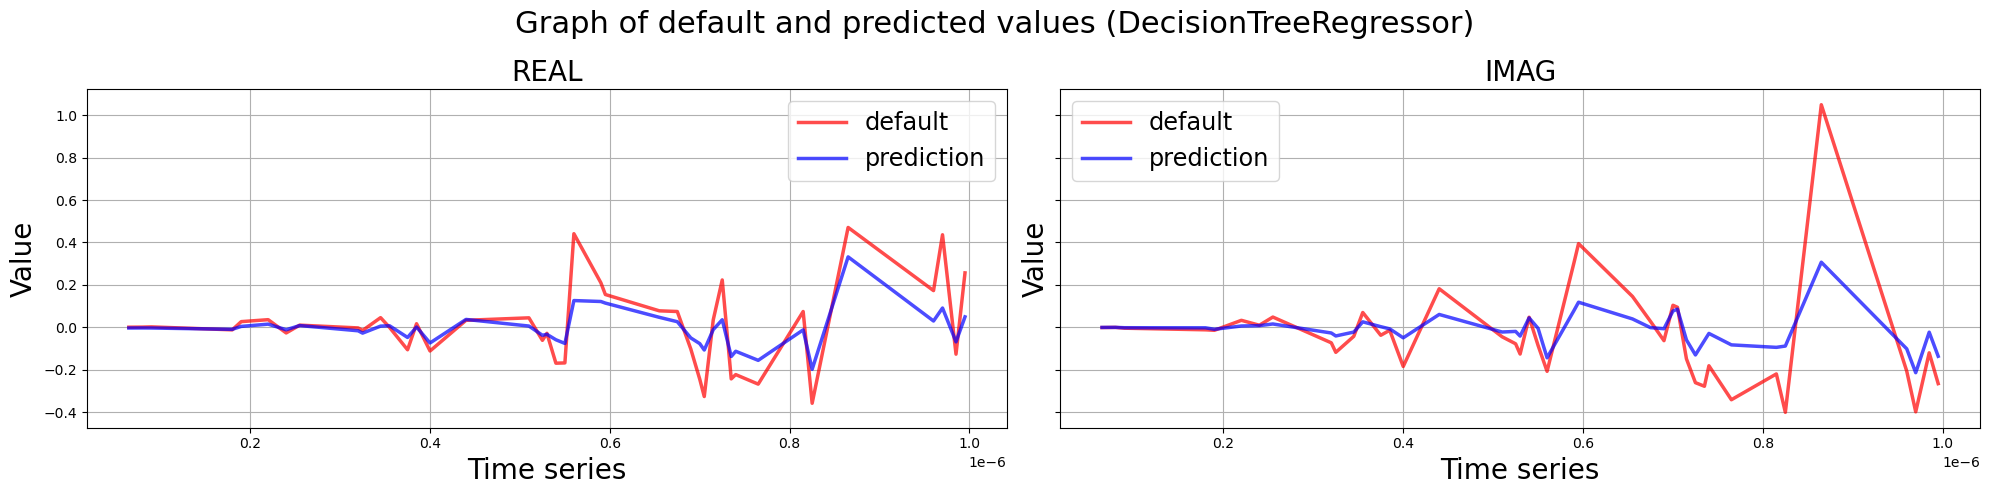

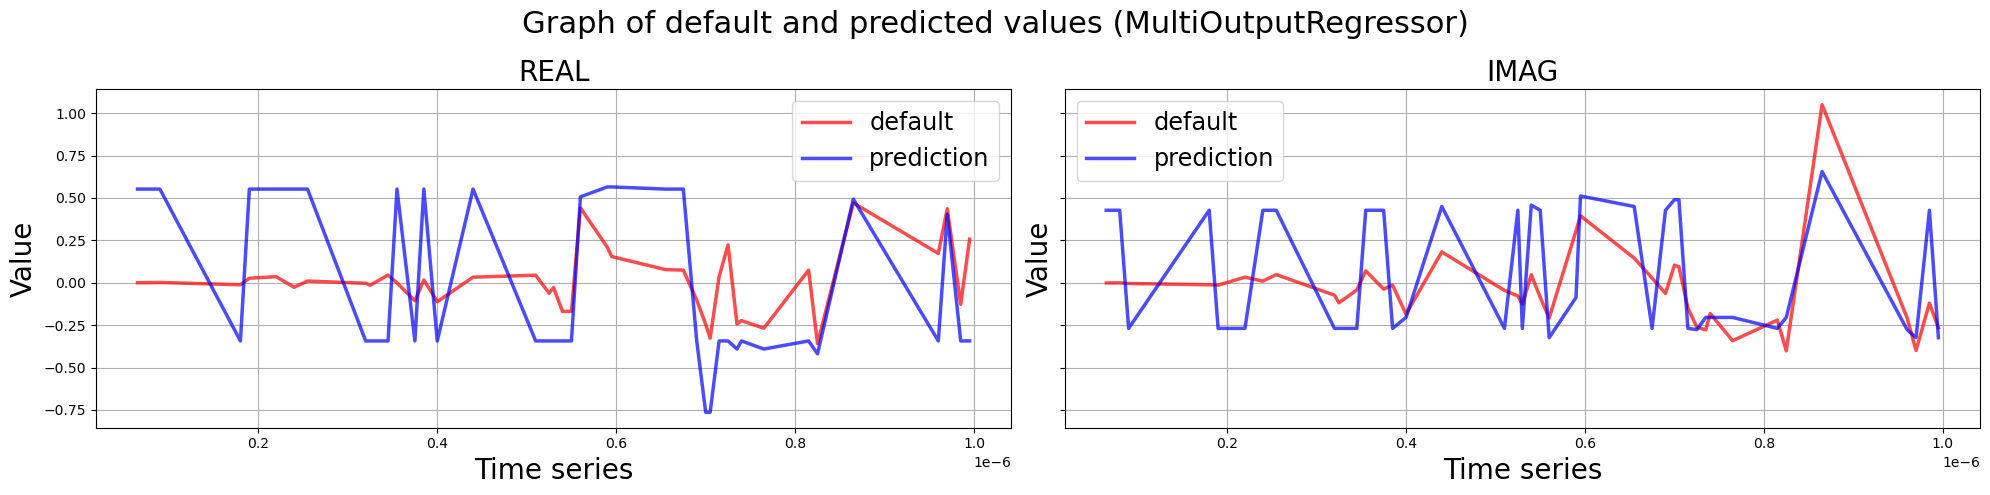

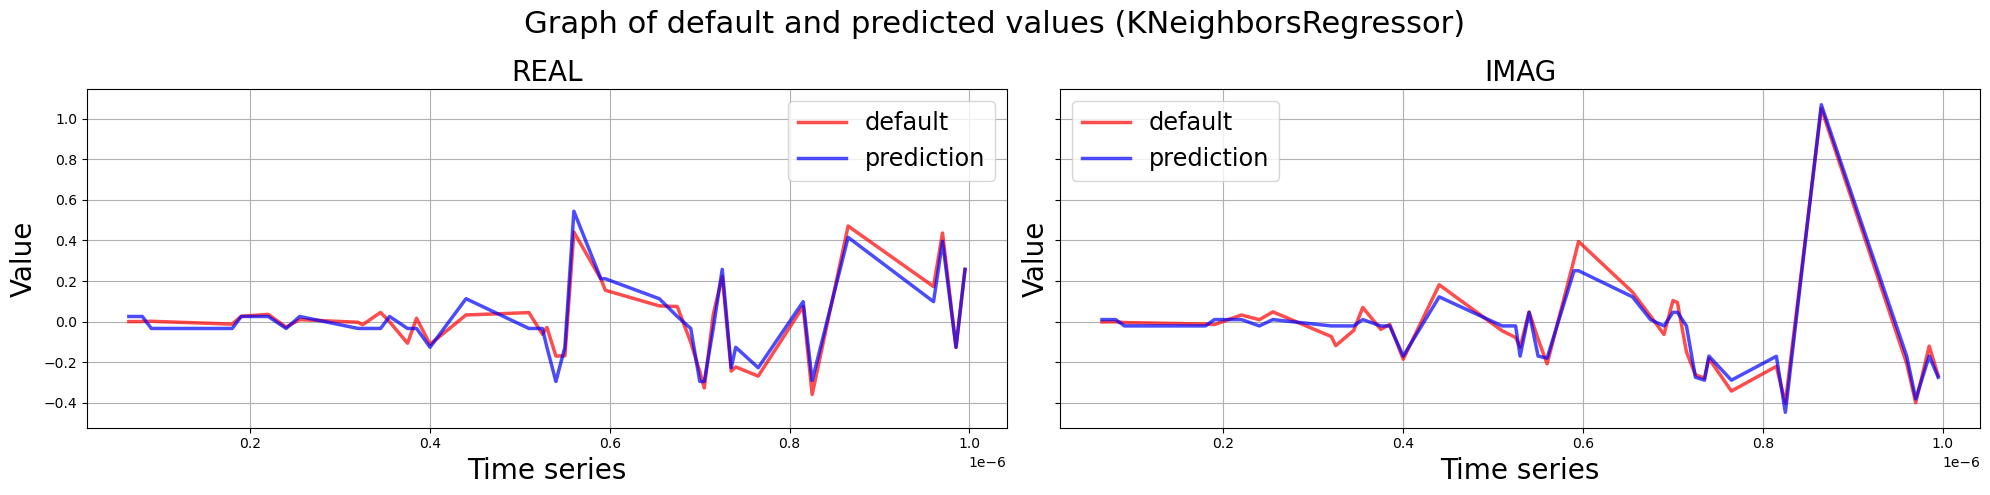

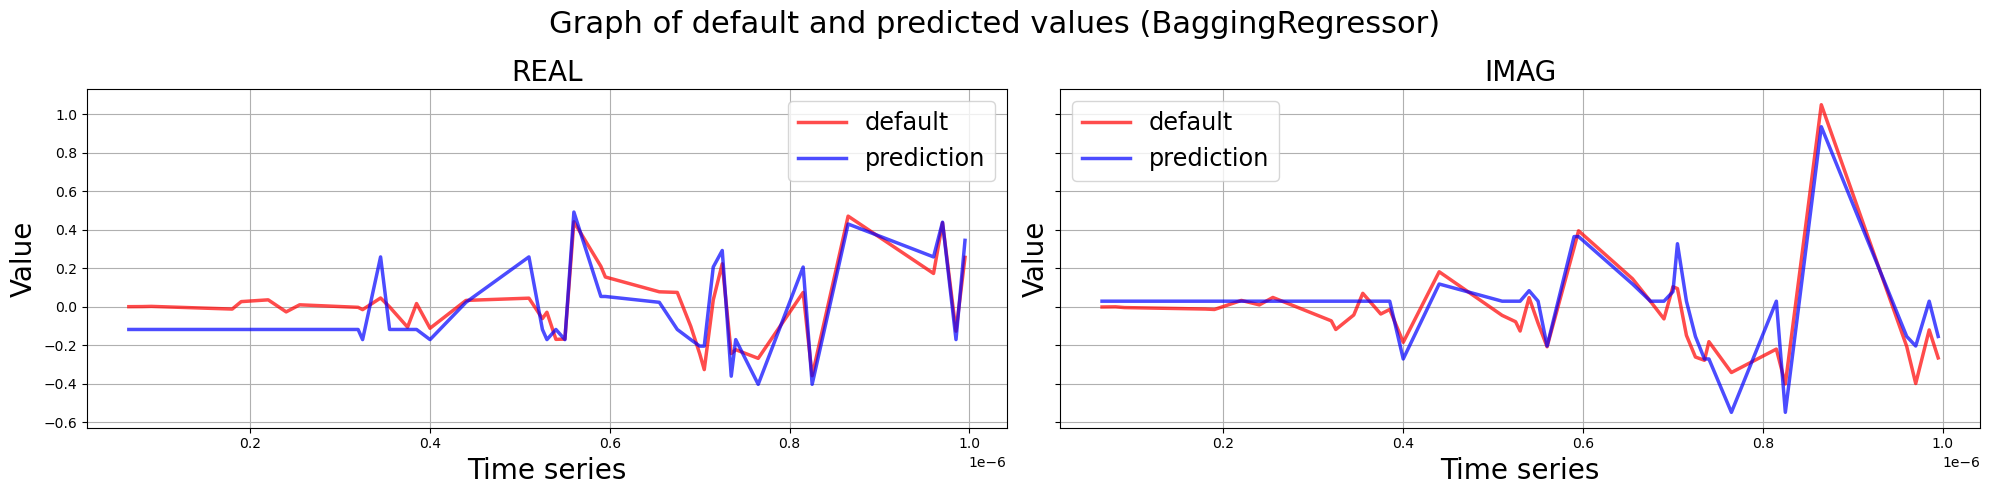

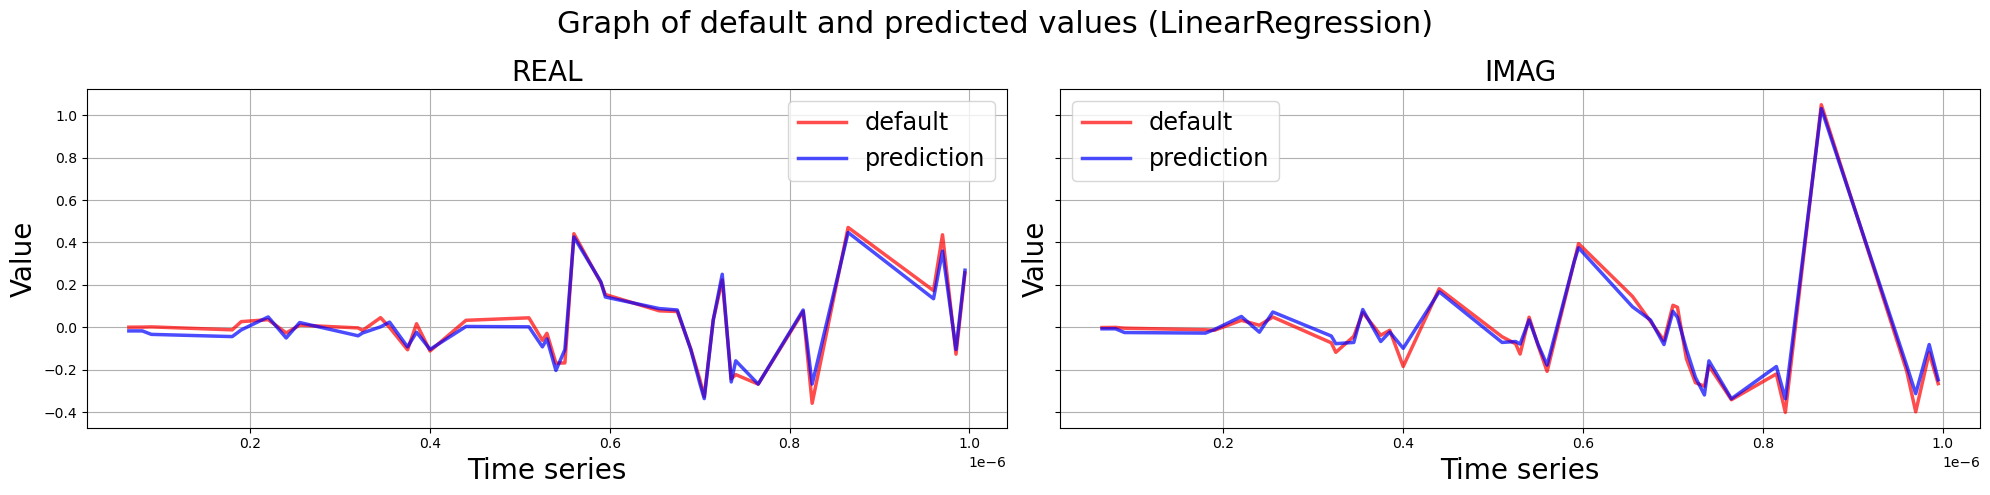

In [76]:
plot_predictions_vs_real(info_result, time_start=0, time_end=1e-6)

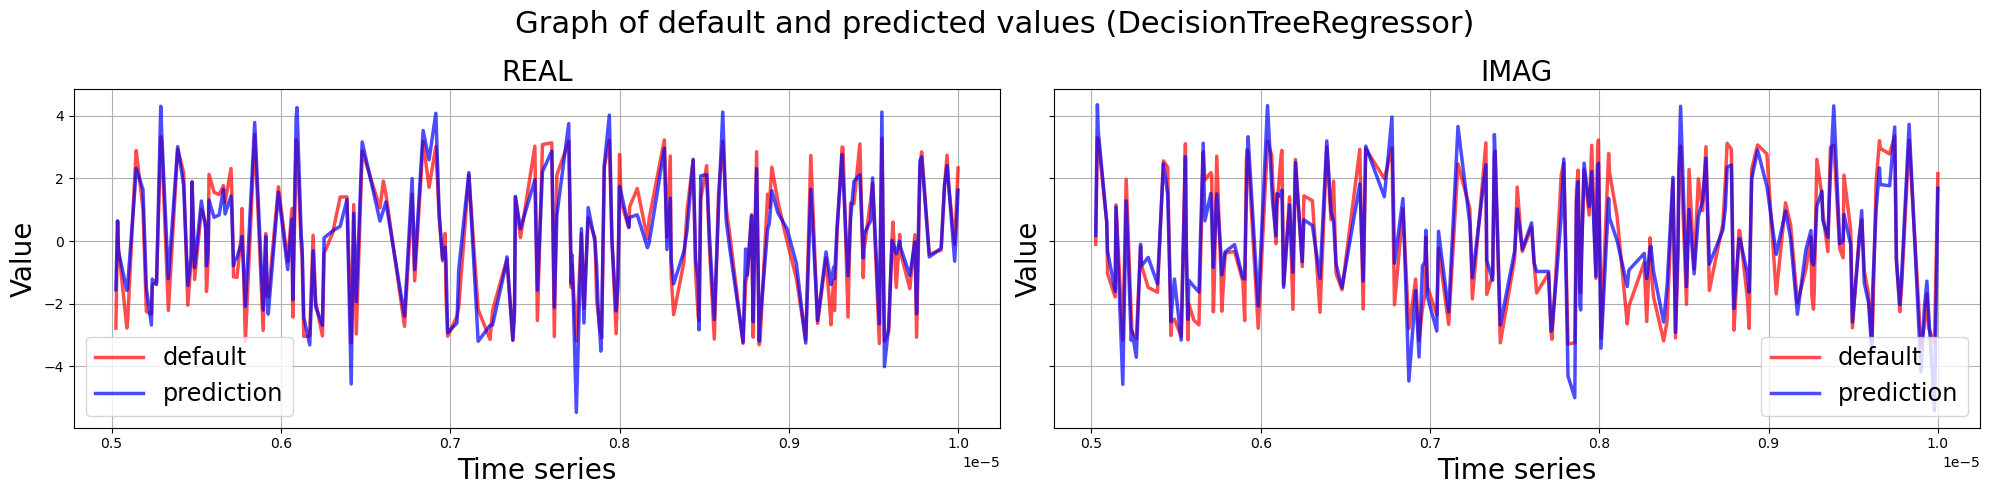

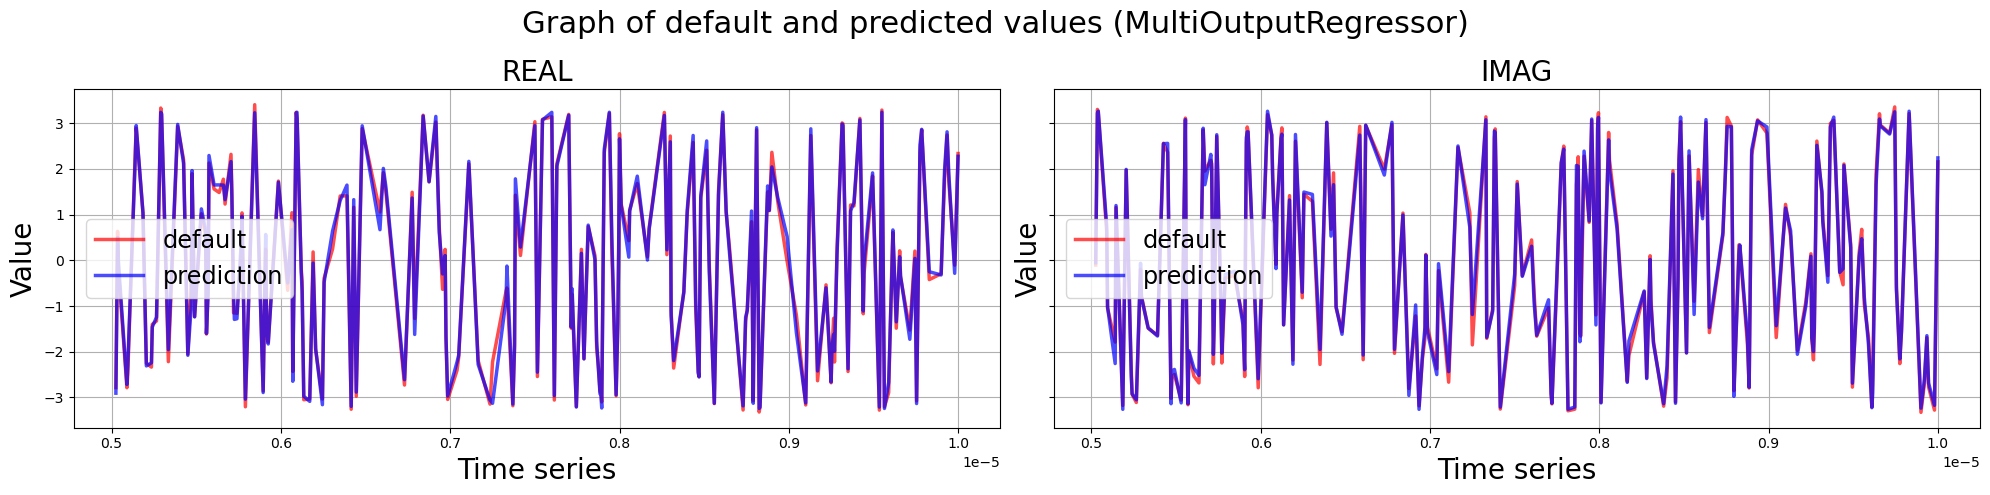

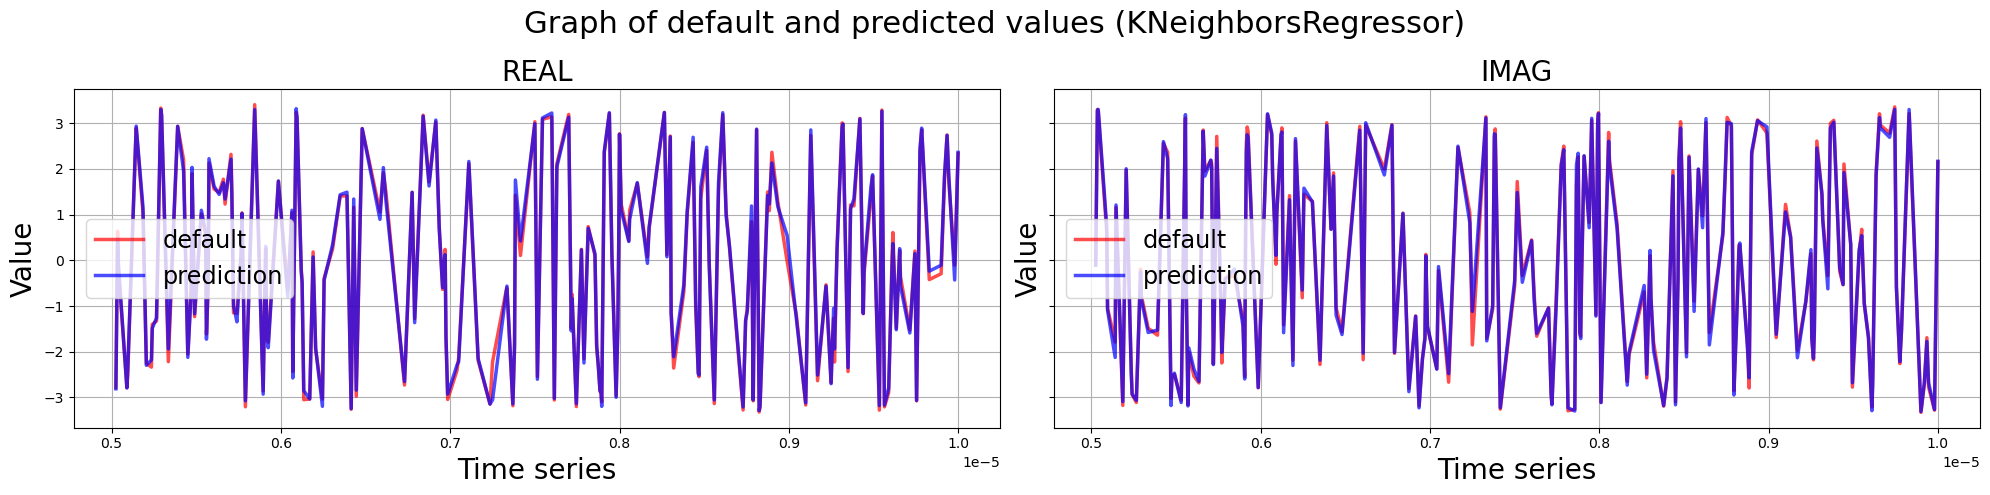

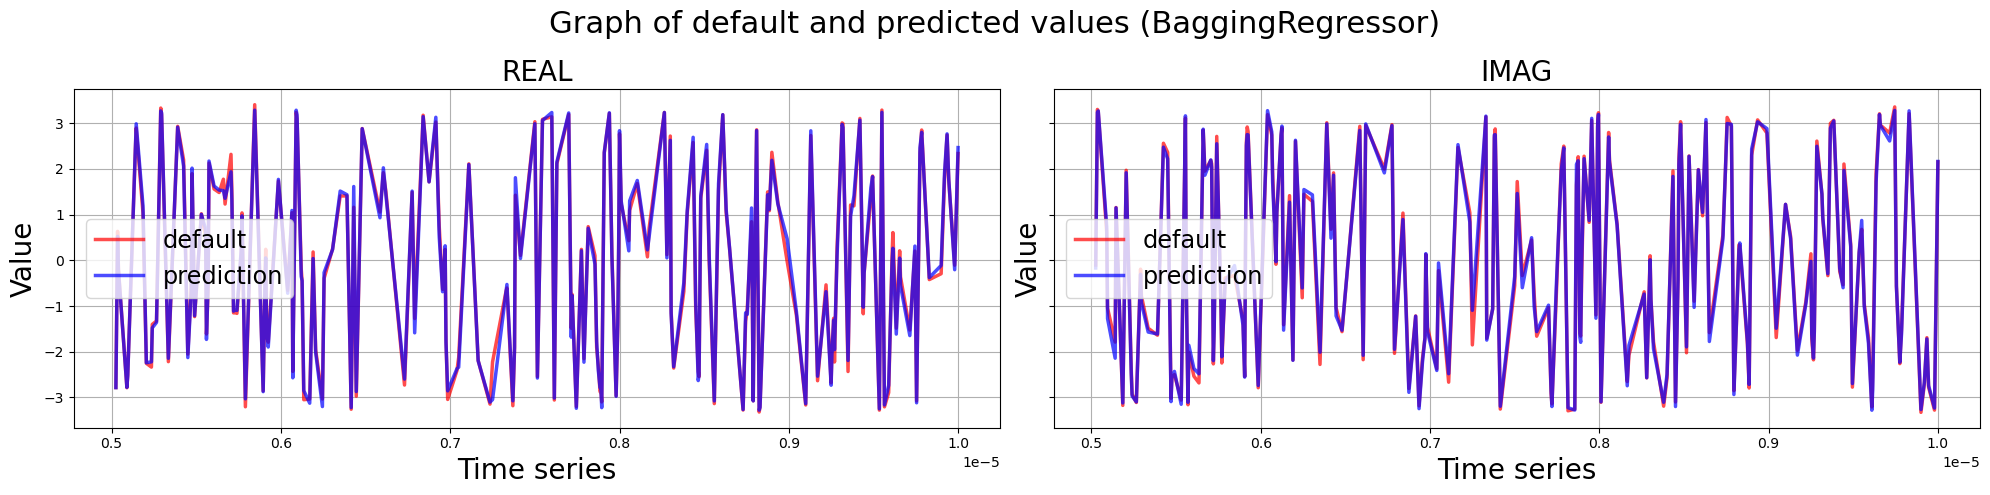

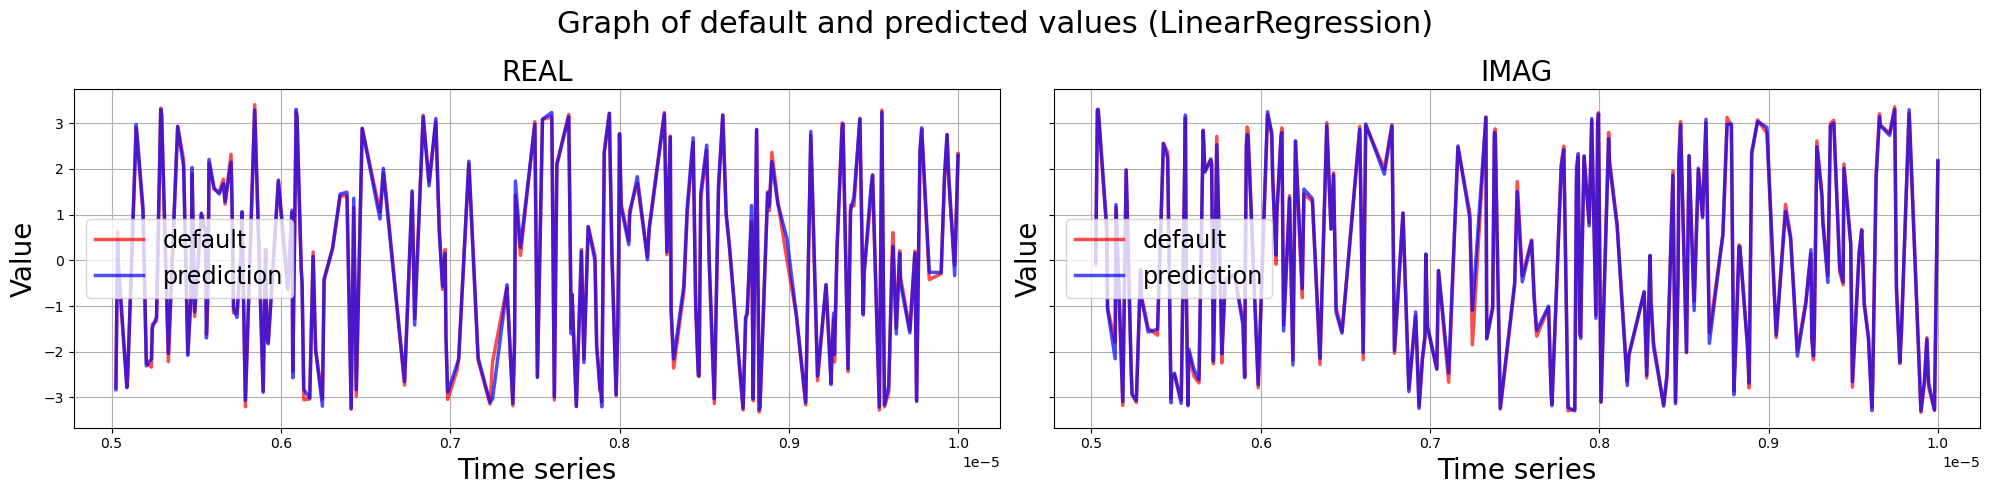

In [80]:
plot_predictions_vs_real(info_result, time_start=0.5e-5, time_end=1e-5)